In [5]:
import gym
import datetime
from agent import QLearning,SARSA

import os,sys
curr_path = os.getcwd()
wapper_dir = '/home/devel/learning/easy-rl-master/codes'
sys.path.insert(0, wapper_dir) 
from envs.gridworld_env import CliffWalkingWapper

from common.plot import plot_rewards
from common.utils import save_results,make_dir
curr_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S") # obtain current time, ep. 20210526-104642

In [6]:
class Config():
    '''训练相关参数'''
    def __init__(self,algo='QLearning',env='CliffWalking-v0',train_eps=300,eval_eps=30):
        self.algo = algo
        self.env = env # 0 up, 1 right, 2 down, 3 left
        self.result_path = curr_path+"/outputs/" +self.env+'/'+curr_time+'/'+algo+'/results/'  # path to save results
        self.model_path = curr_path+"/outputs/" +self.env+'/'+curr_time+'/'+algo+'/models/'  # path to save models
        self.train_eps = train_eps # 训练的episode数目
        self.eval_eps = eval_eps
        self.gamma = 0.9 # reward的衰减率
        self.epsilon_start = 0.95 # e-greedy策略中初始epsilon
        self.epsilon_end = 0.01 # e-greedy策略中的终止epsilon
        self.epsilon_decay = 200 # e-greedy策略中epsilon的衰减率
        self.lr = 0.1 # learning rate

In [7]:
def init_env_agent(cfg,seed=1):
    ### initial environment ### 
    env = gym.make(cfg.env)  
    if cfg.env == 'CliffWalking-v0':
        env = CliffWalkingWapper(env)
    env.seed(seed)
    
    ### initial agent ### 
    state_dim = env.observation_space.n
    action_dim = env.action_space.n
    if cfg.algo == 'QLearning':
        agent = QLearning(state_dim,action_dim,cfg)
    elif cfg.algo == 'SARSA':
        agent = SARSA(state_dim,action_dim,cfg)
    return env,agent

In [12]:
def try_env():
    env = gym.make("CliffWalking-v0")
    env = CliffWalkingWapper(env)

    actions = ['Up','Right','Down','Left']
    actions_arrow = ['↑','→','↓','←']

    obs = env.reset()  # 重置一个 episode
    for i in range(100):
        print('ROUND',i)
        env.render()  # 显示图形界面
        print('\nFROM',obs)
        action = env.action_space.sample() # 从动作空间中随机选取一个动作
        print(actions[action])
        obs, reward, done , _ = env.step(action) # 用于提交动作，括号内是具体的动作
        print('END',obs)
        print('-'*10)
    env.close() # 关闭环境

In [1]:
# import matplotlib
# matplotlib.use('Agg')  

# import turtle
# turtle.Turtle()

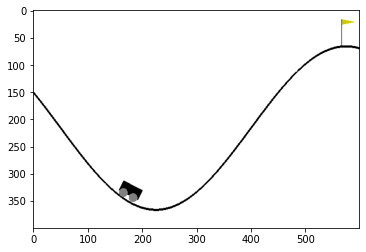

In [1]:
import gym
from IPython import display
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# env = gym.make('MountainCar-v0')

env.reset()
img = plt.imshow(env.render(mode='rgb_array')) # only call this once
for _ in range(100):
    img.set_data(env.render(mode='rgb_array')) # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)
    action = env.action_space.sample()
    env.step(action)

In [14]:
# try_env()

In [6]:
def train(cfg,env,agent):
    ma_rewards,rewards = [],[]
    for i in range(cfg.train_eps):
        eps_reward = 0      # 记录每个episode内的reward
        state = env.reset() # 重置环境, 重新开一局（即开始新的一个episode）
        done = False
        while not done:
            action = agent.sample(state)
            next_state,reward,done,_ = env.step(action)
            if cfg.algo == 'QLearning':
                agent.learn(state,action,reward,next_state,done)
            elif cfg.algo == 'SARSA':
                next_action = agent.sample(next_state)
                agent.learn(state,action,reward,next_state,next_action,done)
                action = next_action
            state = next_state
            eps_reward += reward
        rewards.append(eps_reward)
        if ma_rewards:
            ma_rewards.append(ma_rewards[-1]*0.9+eps_reward*0.1)
        else:
            ma_rewards.append(eps_reward)
        if (i+1)%10==0:
            print(f"Episode:{i+1}/{cfg.train_eps}: reward:{eps_reward:.1f}")        
    return ma_rewards,rewards

In [7]:
def evaluate(cfg,env,agent,render=False):
    ma_rewards,rewards = [],[]
    for i in range(cfg.eval_eps):
        eps_reward = 0      # 记录每个episode内的reward
        state = env.reset() # 重置环境, 重新开一局（即开始新的一个episode）
        done = False
        while not done:
            if render:
                env.render()  #渲染新的一帧图形
            action = agent.predict(state)
            next_state,reward,done,_ = env.step(action)
            state = next_state
            eps_reward += reward
        rewards.append(eps_reward)
        if ma_rewards:
            ma_rewards.append(ma_rewards[-1]*0.9+eps_reward*0.1)
        else:
            ma_rewards.append(eps_reward)
        if (i+1)%10==0:
            print(f"Episode:{i+1}/{cfg.eval_eps}: reward:{eps_reward:.1f}")        
    return ma_rewards,rewards

In [2]:
def main():
    algo = 'QLearning' 
    cfg = Config(algo)
    env,agent = init_env_agent(cfg,seed=1)
    ma_rewards,rewards = train(cfg,env,agent)
    make_dir(cfg.result_path,cfg.model_path)
    agent.save(path=cfg.model_path)
    save_results(rewards,ma_rewards,tag='train',path=cfg.result_path)
    plot_rewards(rewards,ma_rewards,tag="train",env=cfg.env,algo = cfg.algo,path=cfg.result_path)

    env,agent = init_env_agent(cfg,seed=10)
    agent.load(path=cfg.model_path)
    ma_rewards,rewards = evaluate(cfg,env,agent,render=True)
    save_results(rewards,ma_rewards,tag='eval',path=cfg.result_path)
    plot_rewards(rewards,ma_rewards,tag="eval",env=cfg.env,algo = cfg.algo,path=cfg.result_path)

Episode:10/300: reward:-164.0
Episode:20/300: reward:-63.0
Episode:30/300: reward:-42.0
Episode:40/300: reward:-43.0
Episode:50/300: reward:-70.0
Episode:60/300: reward:-51.0
Episode:70/300: reward:-79.0
Episode:80/300: reward:-49.0
Episode:90/300: reward:-71.0
Episode:100/300: reward:-39.0
Episode:110/300: reward:-22.0
Episode:120/300: reward:-49.0
Episode:130/300: reward:-29.0
Episode:140/300: reward:-28.0
Episode:150/300: reward:-25.0
Episode:160/300: reward:-34.0
Episode:170/300: reward:-20.0
Episode:180/300: reward:-19.0
Episode:190/300: reward:-33.0
Episode:200/300: reward:-18.0
Episode:210/300: reward:-18.0
Episode:220/300: reward:-34.0
Episode:230/300: reward:-23.0
Episode:240/300: reward:-13.0
Episode:250/300: reward:-25.0
Episode:260/300: reward:-14.0
Episode:270/300: reward:-27.0
Episode:280/300: reward:-15.0
Episode:290/300: reward:-17.0
Episode:300/300: reward:-15.0
results saved!


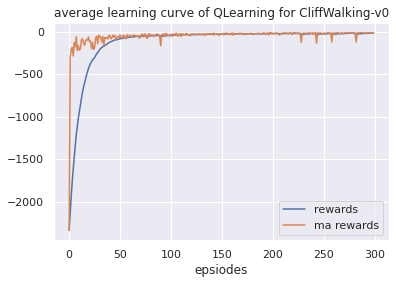

Episode:10/30: reward:-13.0
Episode:20/30: reward:-13.0
Episode:30/30: reward:-13.0
results saved!


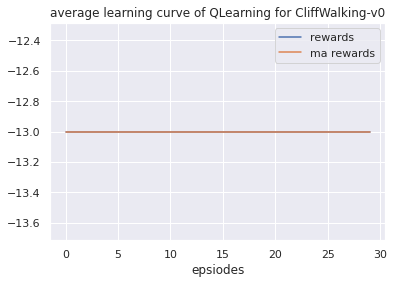

Episode:10/10: reward:-13.0


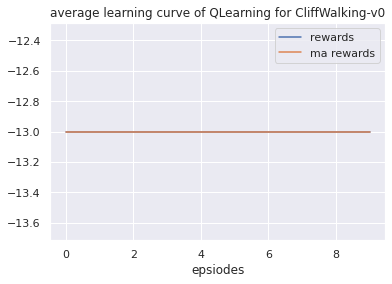

In [10]:
if __name__ == "__main__":
#     algo = 'SARSA'#'QLearning' 
    main()